Total solving time: 0:00:00, 1.9610e-02


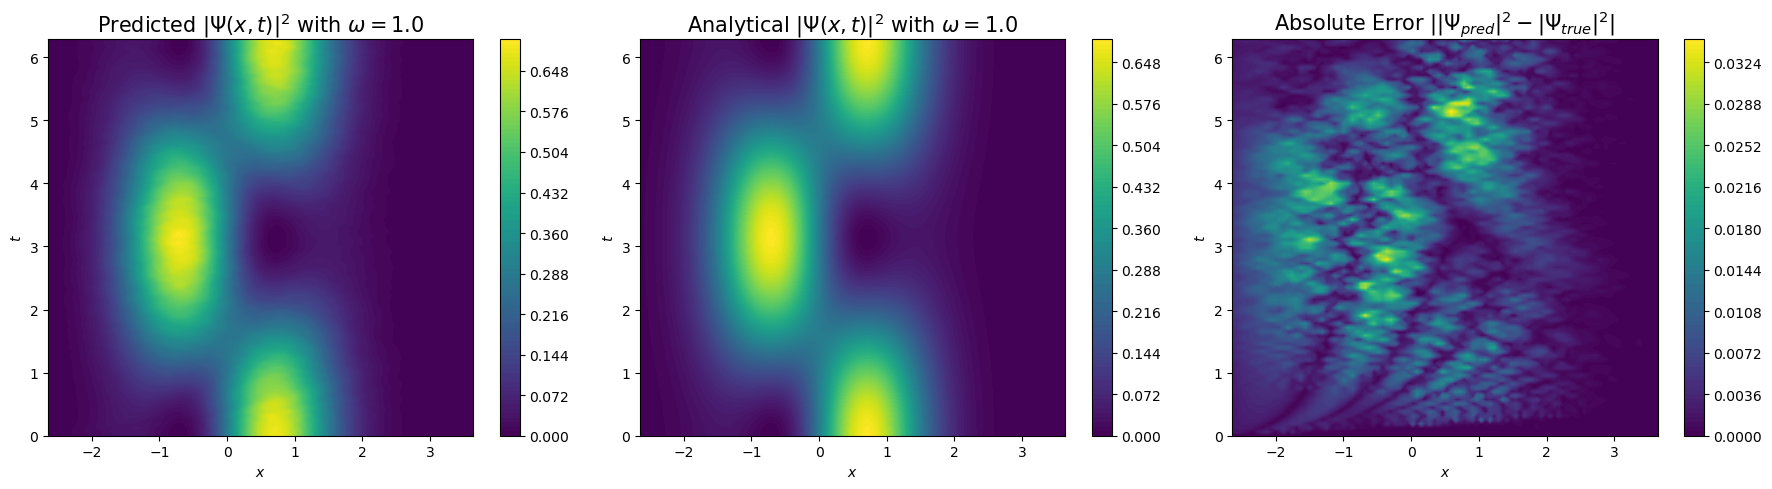

0.4979154141458523


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime

# use float64 for higher precision in PDEs
# tf.keras.backend.set_floatx('float64')
DTYPE = np.float64

# declare inputs entire domain
w_choice = 1.0
x_min, x_max = -np.pi, np.pi
t_min, t_max = 0.0 , 2.0*np.pi

# Compute theoretical |Psi(x,t)|^2
def U_0(x, t, w):
    return np.exp(-1j * 0.5 * w * t) * (w/np.pi)**0.25 * np.exp(-w * x**2 / 2.0)
def U_1(x, t, w):
    return np.exp(-1j * 1.5 * w * t) * (w/np.pi)**0.25 * np.exp(-w * x**2 / 2.0) * x * np.sqrt(2.0*w)
def psi_analytic(x, t, w):
    u0 = U_0(x, t, w)
    u1 = U_1(x, t, w)
    return (1.0/np.sqrt(2.0)) * (u0 + u1)

# initial condition
def psi_init(x, w, pi):
    u_0 = (w/pi)**0.25 * np.exp(-0.5*w*x**2)
    u_1 = (w/pi)**0.25 * np.exp(-0.5*w*x**2) * x * np.sqrt(2.0*w)
    return (1.0/np.sqrt(2.0)) * (u_0 + u_1)

# potential
def V(x):
    return 0.5 * w_choice**2 * x**2 

# Start the timer
start_time = time.time()

N = 100                       # Number of grid points
dx = (x_max - x_min) / (N-1)  # Define spatial step size
dt = (t_max - t_min) / (N-1)  # Define temporal step size

noise = np.random.rand()
x = np.linspace(x_min, x_max, N, dtype=DTYPE) + noise  # Define grid points
t = np.linspace(t_min, t_max, N, dtype=DTYPE)  # Define grid points
X_grid, T_grid = np.meshgrid(x, t)  # t and x grid

# Create Hamiltonian matrix and calculate its eigenvectors and eigenvalues
T = -0.5 * (np.diag(np.ones(N-1), k=-1) - 2*np.diag(np.ones(N), k=0) + np.diag(np.ones(N-1), k=1)) / (dx**2)
H = (T + np.diag(V(x))) * dt

Lambda, Q = np.linalg.eigh(H)  # Eigenvalues and eigenvectors of H
Q_inv = Q.conj().T  # Inverse of eigenvector Q (i.e., Q^-1 = Q^+)

psi = psi_init(x, w_choice, np.pi)
psi = psi.astype(np.complex128)

density_pred = []
density_pred.append(np.abs(psi)**2)
density_true = []

for i in range(N-1):
    psi = np.dot(Q_inv, psi)     # Expand into eigenfunctions/vectors
    psi *= np.exp(-1j * Lambda)  # Propagate eigenfunctions/vectors
    psi = np.dot(Q, psi)         # Superpose eigenfunctions/vectors

    density_pred.append(np.abs(psi)**2)

# End the timer
end_time = time.time()
# Calculate total execution time
execution_time = end_time - start_time
# Convert to hours, minutes, seconds
execution_time_formatted = str(datetime.timedelta(seconds=int(execution_time)))
print(f"Total solving time: {execution_time_formatted}, {execution_time:.4e}")

for t_val in t:
    psi_val = psi_analytic(x, t_val, w_choice)
    density_t = np.abs(psi_val)**2
    density_true.append(density_t)

# Convert density_pred to a 2D array: shape (N_time, N_space)
density_pred_array = np.array(density_pred)  # shape: (N, N)
density_true_array = np.array(density_true)  # shape: (N, N)
abs_error = np.abs(density_true_array - density_pred_array)

# Flatten x and t grids to match density_pred
x_repeat = np.tile(x, len(t))           # Repeat x for each t
t_tile = np.repeat(t, len(x))           # Repeat each t N times
density_pred_flat = density_pred_array.flatten()  # Flatten 2D density to 1D
density_true_flat = density_true_array.flatten()
error_flat = abs_error.flatten()

# Create DataFrame
df = pd.DataFrame({
    "x": x_repeat,
    "t": t_tile,
    "density_pred": density_pred_flat,
    "density_true": density_true_flat,
    "abs_error": error_flat
})

# Save to CSV
df.to_csv("exact_diag.csv", index=False)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# predicted contour
c0 = axs[0].contourf(X_grid, T_grid, density_pred, levels=100, cmap="viridis")
fig.colorbar(c0, ax=axs[0]) #label=r'$|\Psi(x,t)|^2$'
axs[0].set_xlabel(r'$x$')
axs[0].set_ylabel(r'$t$')
axs[0].set_title(f'Predicted $|\Psi(x,t)|^2$ with $\omega={w_choice}$', fontsize=15)

# true contour
c1 = axs[1].contourf(X_grid, T_grid, density_true, levels=100, cmap="viridis")
fig.colorbar(c1, ax=axs[1]) #, label=r'$|\Psi(x,t)|^2$'
axs[1].set_xlabel(r'$x$')
axs[1].set_ylabel(r'$t$')
axs[1].set_title(f'Analytical $|\Psi(x,t)|^2$ with $\omega={w_choice}$', fontsize=15)

# absolute error contour
c2 = axs[2].contourf(X_grid, T_grid, abs_error, levels=100, cmap="viridis")
fig.colorbar(c2, ax=axs[2]) #, label=r'$|\Psi(x,t)|^2_{pred} - |\Psi(x,t)|^2_{true}$'
axs[2].set_xlabel(r'$x$')
axs[2].set_ylabel(r'$t$')
axs[2].set_title(r'Absolute Error $||\Psi_{pred}|^2 - |\Psi_{true}|^2|$', fontsize=15) # Plot with MSE={mse:.2e}

# Layout and show
# fig.suptitle(f"Comparison of Predicted vs Analytical $|\Psi(x,t)|^2$ with $\omega={w_choice}$", fontsize=16)
plt.tight_layout()
plt.show()

print(noise)

In [12]:
mse = np.mean(np.square(density_true_array - density_pred_array))
print(f"mse={mse:.4e}")

mae = np.mean(np.abs(density_true_array - density_pred_array))
print(f"mae={mae:.4e}")

mse=6.7693e-05
mae=5.6881e-03


In [8]:
# Read CSV back in
df_loaded = pd.read_csv("exact_diag.csv")

# Show first 5 rows
print(df_loaded.tail())

             x         t  density_pred  density_true  abs_error
9995  2.887727  6.283185      0.001224      0.001743   0.000519
9996  2.951193  6.283185      0.000762      0.001246   0.000484
9997  3.014660  6.283185      0.000398      0.000883   0.000485
9998  3.078126  6.283185      0.000151      0.000620   0.000469
9999  3.141593  6.283185      0.000024      0.000432   0.000408


In [11]:
# Read CSV back in
df_loaded = pd.read_csv("pinn_results.csv")

# Show first 5 rows
print(df_loaded.tail())

             x         t  density_pred  density_true  abs_error
9995  2.887727  6.283185  1.090495e-03      0.001743   0.000652
9996  2.951193  6.283185  5.916022e-04      0.001246   0.000654
9997  3.014660  6.283185  2.611117e-04      0.000883   0.000622
9998  3.078126  6.283185  7.020686e-05      0.000620   0.000550
9999  3.141593  6.283185  7.271393e-07      0.000432   0.000432


0.0
0.8885312555607496
1.7770625111214993
2.6655937666822487
3.5541250222429985
4.442656277803748
5.331187533364497
6.283185307179586


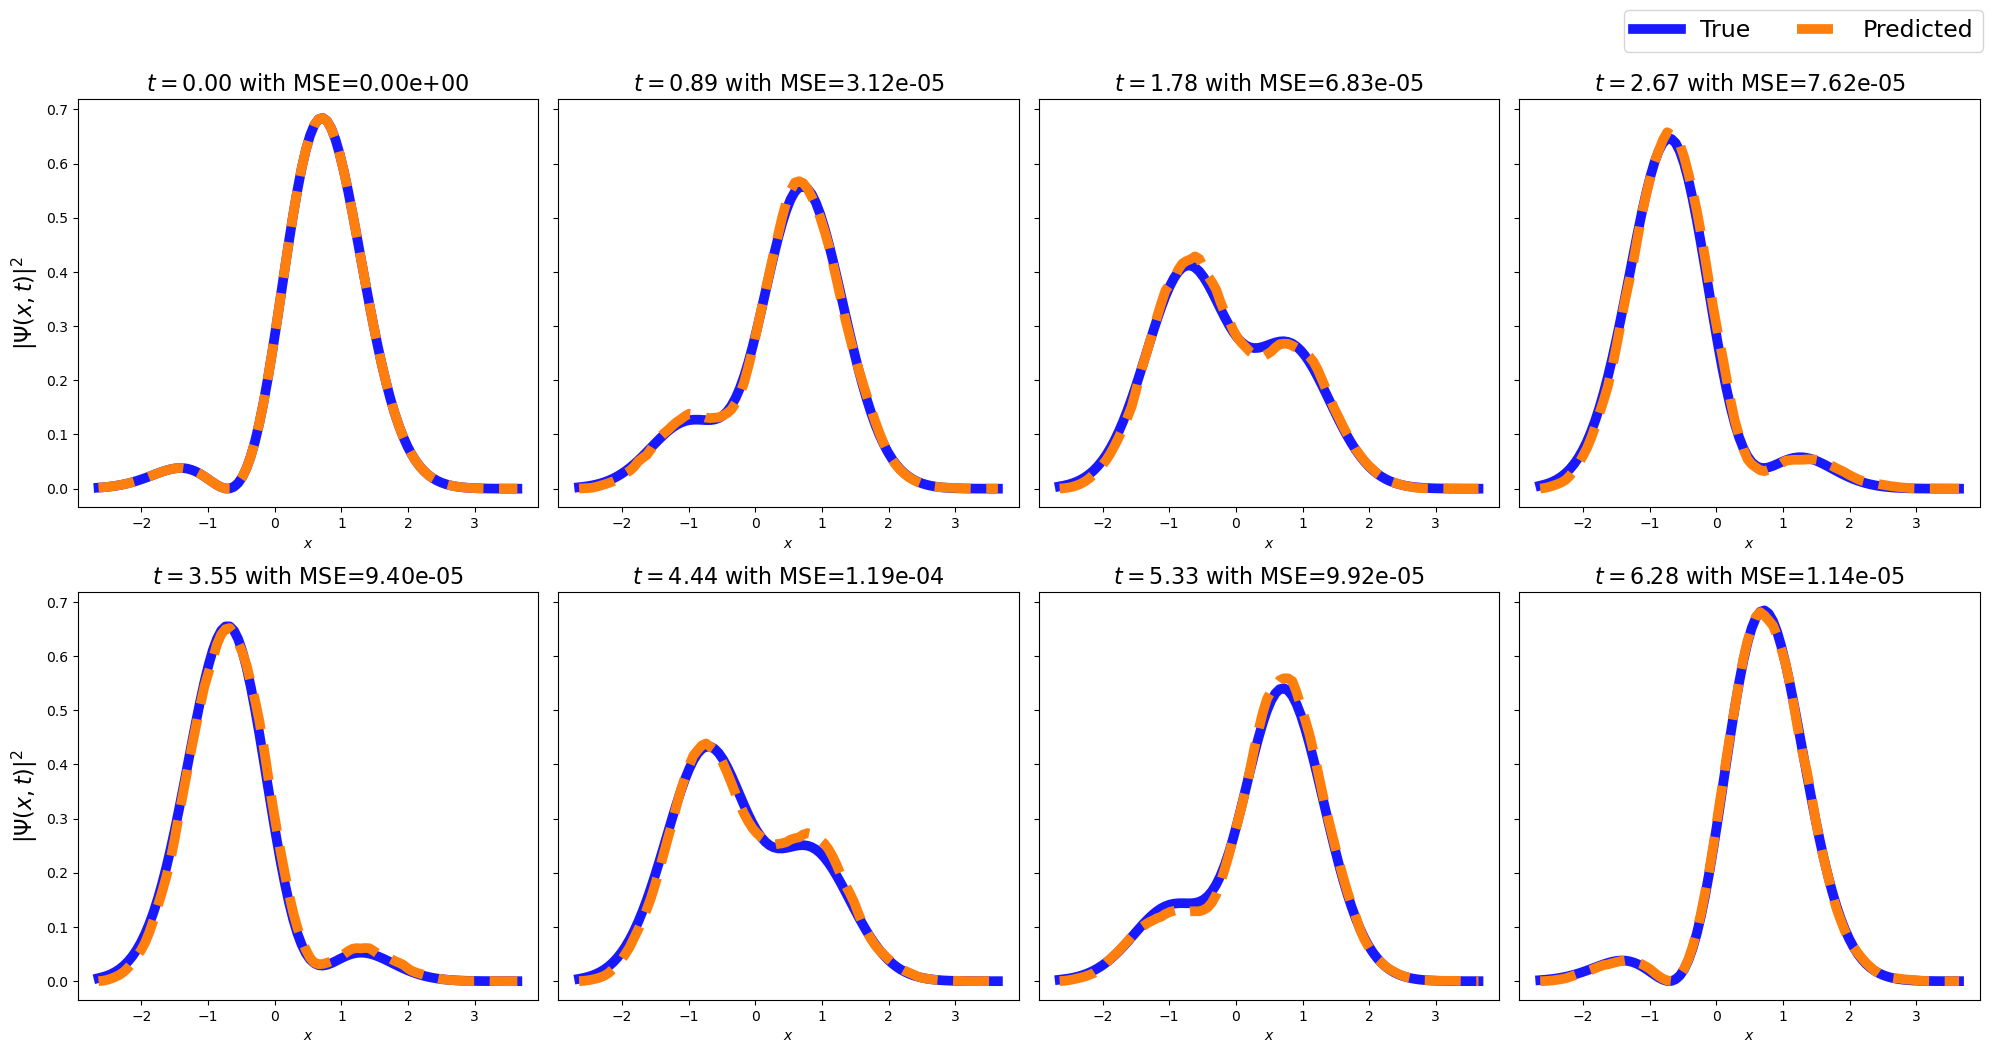

In [11]:
time_indices = np.linspace(0, N-1, 8, dtype=int)
fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
axs = axs.flatten()

for i, idx in enumerate(time_indices):
    x_vals = x
    true_vals = density_true[idx]
    pred_vals = density_pred[idx]
    mse = np.mean((true_vals - pred_vals)**2)

    axs[i].plot(x_vals, true_vals, lw=7, label="True", color='blue', alpha=0.9)
    axs[i].plot(x_vals, pred_vals, lw=7, label="Predicted", color='tab:orange', alpha=1.0, linestyle="dashed")
    axs[i].set_title(f"$t={t[idx]:.2f}$ with MSE={mse:.2e}", fontsize=16)
    axs[i].set_xlabel("$x$")
    # axs[i].grid(True)
    if i == 0 or i == 4:
        axs[i].set_ylabel(r"$|\Psi(x,t)|^2$", fontsize=16)
    
    print(t[idx])

# Add a single legend and adjust layout
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncols=2, bbox_to_anchor=(1, 1.06), fontsize=17)
# fig.suptitle(f"Predicted $|\Psi(x,t)|^2$ at Different Time Steps with $\omega={w_choice}$", fontsize=14)
plt.tight_layout()
plt.show()
